# Imports / Config

In [1]:
from datetime import datetime
import os
import sys

import pandas as pd
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from content_corpus import ContentCorpus

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
%%time
recent_content_corpus = ContentCorpus(verbose=True)

CPU times: user 14 µs, sys: 1 µs, total: 15 µs
Wall time: 20 µs


In [4]:
%%time
recent_content_corpus.load_recent_content(days_of_recent_content=7)

CPU times: user 2min 52s, sys: 17.3 s, total: 3min 10s
Wall time: 21min 48s


In [5]:
%%time
recent_content_corpus.vectorize_content()

CPU times: user 2min 58s, sys: 6.52 s, total: 3min 4s
Wall time: 3min 4s


In [6]:
%%time
recent_content_corpus.classify_content()


 svm classifier performance
 accuracy:   0.902
 classification report: 
                                precision    recall  f1-score   support

 Entertainment, Culture & Arts       0.88      0.96      0.92       951
            Finance & Business       0.81      0.78      0.80       406
  Politics, Policy & Economics       0.85      0.84      0.85       222
                        Sports       0.98      0.99      0.99      1287
Technology, Science & Medicine       0.60      0.52      0.56       161
      Travel, Lifestyle & Food       0.91      0.69      0.78       216

                   avg / total       0.90      0.90      0.90      3243

 confusion matrix: 
[[ 916    6    9   11    3    6]
 [  28  317   13    1   42    5]
 [  20   10  187    3    2    0]
 [  13    0    0 1272    2    0]
 [  14   52    7    0   84    4]
 [  46    6    3    5    8  148]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))



 svm classifier performance
 accuracy:   0.922
 classification report: 
                      precision    recall  f1-score   support

          Asia & ANZ       0.96      0.93      0.95       170
              Europe       0.87      0.73      0.79        85
       Latin America       1.00      0.46      0.63        13
Middle East & Africa       0.98      0.83      0.90        64
       U.S. & Canada       0.91      0.98      0.94       454

         avg / total       0.92      0.92      0.92       786

 confusion matrix: 
[[158   1   0   0  11]
 [  1  62   0   1  21]
 [  0   1   6   0   6]
 [  1   3   0  53   7]
 [  4   4   0   0 446]]
CPU times: user 23.4 s, sys: 1.63 s, total: 25 s
Wall time: 17.7 s


# Frequent Itemsets Clustering

In [364]:
from itertools import combinations
import re

import numpy as np
from orangecontrib.associate.fpgrowth import frequent_itemsets
from scipy import sparse
from scipy.cluster.hierarchy import linkage as agglomerative_cluster
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import spacy # NB: remove
NLP = spacy.load('en_core_web_lg') # NB: remove
NLP.vocab.add_flag(lambda s: s.lower() in spacy.lang.en.stop_words.STOP_WORDS, spacy.attrs.IS_STOP)
from tqdm import tqdm_notebook # NB: remove

import configs
from utils import get_vectors_and_vocab#, lemmatize # NB: remove

In [486]:
topic = 'Politics, Policy & Economics'
regions = ['U.S. & Canada']
MIN_WORDS = 50
filt = (
    (recent_content_corpus.df['topic_classification_predicted'] == topic)
    & (recent_content_corpus.df['region_classification_predicted'].apply(lambda x: x in regions))
#     & (recent_content_corpus.df['text_word_count'] >= MIN_WORDS)
)
indices = np.where(filt)[0]
subset = recent_content_corpus.df[filt].reset_index()
n_articles = len(subset)

In [487]:
class hierarchicalDocumentClusterer(object):
    def __init__(self, docs, ids, collapse_synonyms=False, min_cluster_support=0.01):
        self.docs = docs
        self.ids = ids
        
        # ultimately we want to produce this
        self.clusters_graph = {}
        
        print('get doc vectors/vocab') # NB: make comment
        self.lemmas = []
        self.lemma_2_vector = {}
        for doc in docs:
            doc_lemmas, doc_vectors = lemmatize(doc, single_str_output=False, 
                                                return_vectors=True)
            for lemma, vector in zip(doc_lemmas, doc_vectors):
                self.lemma_2_vector[lemma] = vector
            self.lemmas += [' '.join(doc_lemmas)]
            
        self.count_vectorizer = CountVectorizer(
            lowercase=False, tokenizer=split, ngram_range=(1, 1), min_df=2, max_df=0.5
        )
        self.bool_vectorizer = CountVectorizer(
            lowercase=False, tokenizer=split, ngram_range=(1, 1), min_df=2, max_df=0.5, binary=True
        )
        self.tfidf_transformer = TfidfTransformer(norm='l2', use_idf=False)
        self.doc_vectors_count, self.idx_2_token = get_vectors_and_vocab(self.lemmas, self.count_vectorizer)
        self.lemma_vectors = np.array([self.lemma_2_vector[token] for token in self.idx_2_token])
        self.idx_2_token_init = self.idx_2_token.copy()
        self.doc_vectors_bool = self.bool_vectorizer.fit_transform(self.lemmas)
        
        print('collapse synonyms') # NB: make comment
        if collapse_synonyms:
            self.ac_result = agglomerative_cluster(
                self.lemma_vectors,
                method='average',
                metric='cosine',
                optimal_ordering=False
            ) 
            self.cluster_members = gen_cluster_members(self.ac_result)
            tokens_to_delete = []
            for members in self.cluster_members.values():
                if len(members) > 1:
                    merge_words = [self.idx_2_token[member] for member in members]
                    self.doc_vectors_count[:, members[0]] = (
                        np.sum(self.doc_vectors_count[:, members[1:]], axis=1)
                    )
                    self.doc_vectors_bool[:, members[0]] = (
                        np.max(self.doc_vectors_count[:, members[1:]], axis=1)
                    )
                    tokens_to_delete += members[1:]
            tokens_to_keep = list(set(np.arange(self.doc_vectors_count.shape[1]))-set(tokens_to_delete))
            self.doc_vectors_count = self.doc_vectors_count[:, tokens_to_keep]
            self.idx_2_token = [token 
                                for idx, token in enumerate(self.idx_2_token) 
                                if idx in tokens_to_keep]
            self.doc_vectors_bool = self.doc_vectors_bool[:, tokens_to_keep]

        self.doc_vectors_tfidf = self.tfidf_transformer.fit_transform(self.doc_vectors_count)
        self.token_2_idx = {word:idx for idx, word in enumerate(self.idx_2_token)}
        self.n_tokens = len(self.token_2_idx)
        self.n_docs = len(self.lemmas)

        print('get frequent itemsets') # NB: make comment
        self.MIN_GLOBAL_SUPPORT = configs.MIN_ARTICLES_IN_PERSPECTIVE_CLUSTER / self.n_docs
        self.min_cluster_support = min_cluster_support
        self.frequent_itemsets = [
            sorted([i for i in itemset])
            for itemset, support in frequent_itemsets(self.doc_vectors_count, 
                                                      min_support=self.MIN_GLOBAL_SUPPORT)
        ]
        print('if doc-itemset pairs have the same score, enable np.argmax to choose the largest itemset')
        # NB: make comment
        self.frequent_itemsets = sorted(self.frequent_itemsets, key=lambda x: -len(x))
        self.itemset_2_idx = {tuple(itemset):idx for idx, itemset in enumerate(self.frequent_itemsets)}
        
        
        # structures necessary for production
        self.itemsets_scores = None
        self.docs_clusters = None
        self.clusters = None
        self.clusterdoc_vectors_count = None
        self.clusterdoc_vectors_bool = None
        self.clusterdoc_vectors_tfidf = None
        self.cluster_2_clusterdoc = {}
        self.clusterdoc_2_cluster = {}
        self.clusterdoc_parents = None
        
    
    def gen_clusters_graph(self):
        print('constructing initial itemset scores') # NB: make comment
        self._gen_itemsets_scores(self.doc_vectors_count, 
                                  self.doc_vectors_bool, 
                                  self.doc_vectors_tfidf,
                                  min_itemset_support=self.min_cluster_support)
        
        print('construct initial clusters') # NB: make comment
        self.docs_clusters = np.array([np.argmax(itemset_scores)
                                       # some docs may be unassigned
                                       if np.max(itemset_scores) > -np.inf else -1
                                      for itemset_scores in self.itemsets_scores])
        for doc, cluster in enumerate(self.docs_clusters):
            self._add_doc_to_clusters_graph(doc, cluster)
        self.clusters = np.unique(self.docs_clusters)
        self.clusters = self.clusters[1:] if self.clusters[0] == -1 else self.clusters # don't consider unassigned
        
        print('constructing cluster tree') # NB: make comment
        max_itemset_level = len(self.frequent_itemsets[0])
        for level in np.arange(max_itemset_level, 1, -1):
            print('finding parents for %d clusters' % level) # NB: remove
            self._gen_clusterdoc_vectors()
            self._gen_itemsets_scores(self.clusterdoc_vectors_count,
                                      self.clusterdoc_vectors_bool, 
                                      self.clusterdoc_vectors_tfidf,
                                      min_itemset_support=self.min_cluster_support,
                                      level_to_process=level)
            self._calc_parents(level_to_process=level)
            for clusterdoc, clusterdoc_parent in enumerate(self.clusterdoc_parents):
                cluster = self.clusterdoc_2_cluster[clusterdoc]
                if clusterdoc_parent:
                    self._link_clusters_graph(cluster, clusterdoc_parent)
                    self.docs_clusters[self.docs_clusters == cluster] = clusterdoc_parent
            self.clusters = np.unique(self.docs_clusters)
            self.clusters = self.clusters[1:] if self.clusters[0] == -1 else self.clusters
        
        print('setting parents of 1 clusters')
        for cluster, contents in self.clusters_graph.items():
            if contents['level'] == 1:
                self.clusters_graph[cluster]['parent_cluster'] = -1
                self.clusters_graph[-1]['child_clusters'] += [cluster]
        
        print('freeing memory') # NB: make comment
        self.itemsets_scores = None
        self.docs_clusters = None
        self.clusters = None
        self.clusterdoc_vectors_count = None
        self.clusterdoc_vectors_bool = None
        self.clusterdoc_vectors_tfidf = None
        self.cluster_2_clusterdoc = {}
        self.clusterdoc_2_cluster = {}
        self.clusterdoc_parents = None
    
    
    def _gen_itemsets_scores(self, doc_vectors_count, doc_vectors_bool, doc_vectors_tfidf, 
                             min_itemset_support=0.01, normalize=False, level_to_process=None,
                             itemsets_selection=None):
        # initialized necessary structures
        doc_vectors_bool_full = doc_vectors_bool.toarray()
        n_docs_local = len(doc_vectors_bool_full)
        
        frequent_itemsets_local = ([itemset for idx, itemset in enumerate(self.frequent_itemsets) 
                                    if idx in itemsets_selection]
                                   if itemsets_selection else self.frequent_itemsets)
        n_frequent_itemsets_local = len(frequent_itemsets_local)
        
        docs_itemsets_bool = np.zeros((n_docs_local, n_frequent_itemsets_local))
        self.itemsets_scores = np.full((n_docs_local, n_frequent_itemsets_local), -np.inf)
        tokens_frequent = np.zeros(self.n_tokens)
        for idx, itemset in enumerate(frequent_itemsets_local):
            docs = np.where(np.all(doc_vectors_bool_full[:, itemset], axis=1))[0]
            docs_itemsets_bool[docs, idx] = 1
            tokens_frequent[itemset] = 1

        global_supports = np.sum(doc_vectors_bool_full, axis=0)/n_docs_local
        itemset_supports = (np.dot(np.transpose(doc_vectors_bool_full), docs_itemsets_bool) 
                            / np.sum(docs_itemsets_bool, axis=0))

        # score itemsets
        # TODO: parallelize this
        for doc_i in tqdm_notebook(np.arange(n_docs_local)): # NB: remove
            if (level_to_process 
                and (len(self.frequent_itemsets[self.clusterdoc_2_cluster[doc_i]]) 
                     != level_to_process)):
                continue
            doc_frequent_tokens = np.where(doc_vectors_bool_full[doc_i] * tokens_frequent)[0]
            doc_itemsets = np.where(docs_itemsets_bool[doc_i])[0]
            for itemset_j in doc_itemsets: # score all itemsets to which doc belongs (i.e., are contained in doc)
                score = 0
                for token_k in doc_frequent_tokens: # todo: 
                    tfidf = doc_vectors_tfidf[doc_i, token_k] 
                    if itemset_supports[token_k, itemset_j] >= min_itemset_support:
                        score += tfidf * itemset_supports[token_k, itemset_j]
                    else:  
                        score -= tfidf * global_supports[token_k]
                self.itemsets_scores[doc_i, itemset_j] = score
        
        if normalize:
            doc_vectors_count_full = doc_vectors_count.toarray()
            doc_word_counts = np.sum(doc_vectors_count_full, axis=1)
            self.self.itemsets_scores /= doc_word_counts
    
    
    def _add_doc_to_clusters_graph(self, doc, cluster):
        if cluster not in self.clusters_graph:
            self._gen_clusters_graph_record(cluster)
        record = self.clusters_graph[cluster]
        record['n_docs'] += 1
        record['docs'] += [self.docs[doc]]
        record['lemmas'] += [self.lemmas[doc]]
        record['ids'] += [self.ids[doc]]
        self.clusters_graph[cluster] = record
        
    
    def _gen_clusters_graph_record(self, cluster):
        record = {
            'cluster': cluster,
            'level': len(self.frequent_itemsets[cluster])
                     if cluster >= 0 else 0,
            'keywords': [self.idx_2_token[item] 
                         for item in self.frequent_itemsets[cluster]] 
                        if cluster >= 0 else [],
            'parent_cluster': None,
            'child_clusters': [],
            'n_docs': 0,
            'docs': [],
            'lemmas': [],
            'ids': [],
            'summary': None
        }
        self.clusters_graph[cluster] = record
    
    
    def _gen_clusterdoc_vectors(self):
        n_clusters = len(self.clusters)
        doc_vectors_count_full = self.doc_vectors_count.toarray()
        
        clusterdoc_vectors_count_full = np.zeros((n_clusters, self.n_tokens))
        self.cluster_2_clusterdoc = {}
        self.clusterdoc_2_cluster = {}
        for clusterdoc, cluster in enumerate(self.clusters):
            self.cluster_2_clusterdoc[cluster] = clusterdoc
            self.clusterdoc_2_cluster[clusterdoc] = cluster
            doc_indices = np.where(self.docs_clusters == cluster)[0]
            combined_counts = np.sum(doc_vectors_count_full[doc_indices, :], axis=0)
            clusterdoc_vectors_count_full[clusterdoc] = combined_counts

        clusterdoc_vectors_bool_full = (clusterdoc_vectors_count_full > 0).astype('int')

        # convert to sparse
        self.clusterdoc_vectors_count = sparse.csr_matrix(clusterdoc_vectors_count_full)
        self.clusterdoc_vectors_bool = sparse.csr_matrix(clusterdoc_vectors_bool_full)
        self.clusterdoc_vectors_tfidf = self.tfidf_transformer.fit_transform(
            self.clusterdoc_vectors_count
        )
        
    
    def _calc_parents(self, level_to_process):
        n_clusters = len(self.clusters)
        self.clusterdoc_parents = np.full(n_clusters, None)
        for cluster in self.clusters:
            clusterdoc = self.cluster_2_clusterdoc[cluster]
            members = self.frequent_itemsets[cluster]
            level = len(members)
            if level != level_to_process:
                continue
            potential_parents = [self.itemset_2_idx[combo] for combo in combinations(members, level-1)]
            best_score = -np.inf
            parent = None
            for potential_parent in potential_parents:
                score = self.itemsets_scores[clusterdoc, potential_parent]
                if score > best_score:
                    parent = potential_parent
                    best_score = score        
            self.clusterdoc_parents[clusterdoc] = parent
            
            
    def _link_clusters_graph(self, child_cluster, parent_cluster):
        # set children
        if parent_cluster not in self.clusters_graph:
            self._gen_clusters_graph_record(parent_cluster)
        record = self.clusters_graph[parent_cluster]
        record['child_clusters'] += [child_cluster]
        self.clusters_graph[parent_cluster] = record
        # set parent
        record = self.clusters_graph[child_cluster]
        record['parent'] = parent_cluster
        self.clusters_graph[child_cluster] = record
        
    
    def get_cluster_contents(self, cluster, drill_down=True):
        contents = self.clusters_graph[cluster].copy()
        if drill_down:
            kw = contents['keywords']
            ids = [(cluster, kw, contents['ids'])]
            docs = [(cluster, kw, contents['docs'])]
            lemmas = [(cluster, kw, contents['lemmas'])]
            for child in contents['child_clusters']:
                child_kw = self.clusters_graph[child]['keywords']
                ids += [(child, child_kw, self._pick_from_tree(child, 'ids'))]
                docs += [(child, child_kw, self._pick_from_tree(child, 'docs'))]
                lemmas += [(child, child_kw, self._pick_from_tree(child, 'lemmas'))]
            contents['ids'] = sorted(ids, key = lambda x: -len(x[2]))
            contents['docs'] = sorted(docs, key = lambda x: -len(x[2]))
            contents['lemmas'] = sorted(lemmas, key = lambda x: -len(x[2]))

        return contents

    
    def _pick_from_tree(self, start_cluster, field):
        to_return = self.clusters_graph[start_cluster][field]
        child_clusters = self.clusters_graph[start_cluster]['child_clusters']
        for child in child_clusters:
            to_return += self._pick_from_tree(child, field)        
        return to_return
            

In [488]:
def clean(doc):
    strip_terms = [
        '| Bangkok Post: news',
        'FOX NEWS FIRST:',
        '| Miami Herald',
        "'s", "’s", "‘s",
        "'", "’", "‘", ',', '.', '!', '?', ':', ';', '(', ')', '|', '-'
    ]
    for term in strip_terms:
        if term in doc:
            doc = doc.replace(term, '')
    return doc


def lemmatize(text, pos_to_keep=['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV'],
              override_pos_filter=False, single_str_output=True, incl_pos=False,
              return_vectors=False):
    """
    Decomposes text into lemma tokens.

    Keyword arguments:
    text - text to decompose  (string)
    pos_to_keep - spacy-abbreviated part-of-speech types; a word's lemma will only appear
        in output if it is one of these types (list of strings, default: ['NOUN', 'PROPN',
        'VERB', 'ADJ', 'ADV'])
    override_pos_filter - if True, pos_to_keep is ignored and all parts of speech are kept
        (boolean, default: False)
    single_str_output - if True, output lemmas as a single string; if False, output lemmas as a
        list of strings (boolean, default: True)
    include_pos - whether to concanate a pos string suffix onto each token's lemma string
    return_vectors - whether to additionally return a list of token embeddings

    Returns:
    list of strings or string (if single_str_output) - text in lemmatized form
    list of arrays (if return_vectors) - text in vector form

    """
    doc = NLP(text, disable=['parser', 'ner'])
    lemmas = []
    vectors = []
    for token in doc:
        if ((not token.is_stop)
            and (not (return_vectors and not token.has_vector))
            and (token.pos_ in pos_to_keep
                 or override_pos_filter)):
            lem = (token.lemma_ 
                   if not token.lemma_ == '-PRON-'
                   else token.string)
            if incl_pos:
                lemmas += [lem+'_'+token.pos_]
            else:
                lemmas += [lem]
            if return_vectors:
                vectors += [token.vector]
    if single_str_output:
        lemmas = ' '.join(lemmas)
    if return_vectors:
        return lemmas, vectors
    return lemmas


def split(inp_str):
    return inp_str.split(' ')


def gen_cluster_members(ac_result, max_dist=0.1):
    """
    Given the output of a scipy agglomerative clustering and some max dist, 
        generates cluster assignments.

    Keyword arguments:
    ac_result - the Z output from scipy linkage (nx4 numpy array; see scipy docs)
    max dist - max dist for clusters to be merged (float)

    Returns:
    dict - cluster assignments in the form {cluster:[members]}

    """
    n_obs = len(ac_result) + 1
    cluster_members = {}
    for i in np.arange(0, n_obs):
        cluster_members[i] = [i]
    for n, clustering in enumerate(ac_result):
        dist = clustering[2]
        if dist > max_dist:
            break
        cluster_id = n + n_obs
        lc = clustering[0]
        rc = clustering[1]
        cluster_members[cluster_id] = cluster_members[lc] + cluster_members[rc]
        del cluster_members[lc]
        del cluster_members[rc]

    return cluster_members

In [489]:
%%time
# docs = list(subset['text'].apply(lambda x: ' '.join(x.split(' ')[:MIN_WORDS])).apply(clean))
docs = list(subset['title'].apply(clean))
ids = list(subset['_id'])

CPU times: user 78.7 ms, sys: 67.4 ms, total: 146 ms
Wall time: 61.1 ms


In [490]:
%%time
HDC = hierarchicalDocumentClusterer(docs, ids, collapse_synonyms=True)

get doc vectors/vocab
collapse synonyms


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


get frequent itemsets
if doc-itemset pairs have the same score, enable np.argmax to choose the largest itemset
CPU times: user 1min 3s, sys: 10 s, total: 1min 13s
Wall time: 58.9 s


In [443]:
%%time
HDC.gen_clusters_graph()

constructing initial itemset scores



construct initial clusters
constructing cluster tree
finding parents for 11 clusters



finding parents for 10 clusters



finding parents for 9 clusters



finding parents for 8 clusters



finding parents for 7 clusters



finding parents for 6 clusters



finding parents for 5 clusters



finding parents for 4 clusters



finding parents for 3 clusters



finding parents for 2 clusters



setting parents of 1 clusters
freeing memory
CPU times: user 49min 1s, sys: 3min 25s, total: 52min 26s
Wall time: 47min 53s


In [444]:
level_0_contents = HDC.get_cluster_contents(-1)

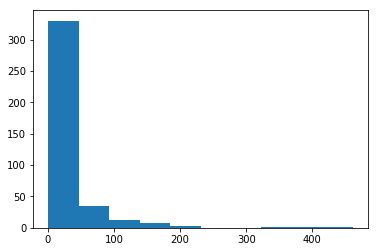

In [445]:
plt.hist([len(x[2]) for x in level_0_contents['docs']])
plt.show()

In [446]:
len(level_0_contents['docs'])

391

In [459]:
i = 6
print(len(level_0_contents['docs'][i][2]))
level_0_contents['docs'][i]

173


(4810,
 ['poll'],
 ['No this poll does not show Canadian voter intentions\n\nAn online post claims that Canadian Prime Minister Justin Trudeau ranks third in a poll with 16 percent of voting intentions for the federal election far behind Conservative Andrew Scheer with 63 percent However the company that produced the poll to which',
  'As Americans go to the polls this fall they are voting for much more than\n\nAs Americans go to the polls this fall they are voting for much more than candidates Their votes will determine whose vote counts in every election moving forward\n\nIt has become increasingly difficult to talk about voting',
  'The results of the Nov 6 elections could have sweeping ramifications for education policy in dozens of states across the country Brendan Smialowski/AFP/Getty Images\n\nIt unlikely education is an issue driving people to the polls this 2018 midterm election In fact in a Gallup poll published in October only 2 percent',
  'Oct 31 UPI — A new Gallup survey 

In [460]:
print(len(level_0_contents['lemmas'][i][2]))
level_0_contents['lemmas'][i]

173


(4810,
 ['poll'],
 ['poll canadian voter intention online post claim canadian prime minister justin trudeau rank poll percent vote intention federal election far conservative andrew scheer percent company produce poll',
  'americans poll fall vote americans poll fall vote candidate vote determine vote count election move forward increasingly difficult talk vote',
  'result nov election sweeping ramification education policy dozen state country brendan afp getty images unlikely education issue drive people poll midterm election fact gallup poll publish october percent',
  'oct upi new gallup survey wednesday suggest trouble await republicans midterm election poll measure national satisfaction direction united states head percent approve low midterm average percent high',
  'steve break potential effect midterm youth vote copy young people plan vote midterm midterm election accord new poll harvard high turnout decade steve break',
  'steve break potential effect midterm youth vote copy y